In [1]:
import pandas as pd

DATA = '../Data/Customers_clustered.csv'

df_clusterd = pd.read_csv(DATA)

In [2]:
df_clusterd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

In [3]:
X = df_clusterd.drop('Response', axis=1)
y = df_clusterd['Response']

In [4]:
#OneHotEncolder para colunas categóricas
one_hot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    'cluster'
]

#Standard para colunas com distribuição normal
standard_cols = [
    "Income",
    "Age",
]


#PowerTransform para colunas que parecem potência, tem um decaimento muito acentuado
power_cols = X.columns[
   X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()



minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]

### Analisando o Modelo de Logistic Regression sem otimização de hiperparâmetro para ter uma ideia inicial antes de fazermos todo o procedimento de otimização

In [5]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # atenção para o Pipeline do ImbLearn para dados desbalanceados
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)



preprocessing = ColumnTransformer(
    [
        ("one-hot", OneHotEncoder(), one_hot_cols),
        ("standard", StandardScaler(), standard_cols),
        ("minmax", MinMaxScaler(), minmax_cols),
        ("power", PowerTransformer(), power_cols),
    ]
)

pipeline_log_reg = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
        ("rus", RandomUnderSampler(random_state=RANDOM_STATE)), #balanceando a base
        ("model", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)


pipeline_log_reg.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one-hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'AcceptedCmpTotal',
                                                   'cluster']),
                                                 ('standard', Stan...
                                                  ['MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal', 'MntProds',
                                                   'NumTotalPurchases'])])),
                ('feature_selection', SelectKBest()),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

In [6]:
#Qunatidades de colunas que saíram do preprocessamento

len(pipeline_log_reg[:-3].get_feature_names_out())

65

In [7]:
pipeline_log_reg[:-1].get_feature_names_out()

array(['one-hot__HasAcceptedCmp_0', 'one-hot__HasAcceptedCmp_1',
       'one-hot__AcceptedCmp1_0', 'one-hot__AcceptedCmp1_1',
       'one-hot__AcceptedCmp3_0', 'one-hot__AcceptedCmp3_1',
       'one-hot__AcceptedCmp5_0', 'one-hot__AcceptedCmp5_1',
       'one-hot__AcceptedCmpTotal_0', 'one-hot__AcceptedCmpTotal_3'],
      dtype=object)

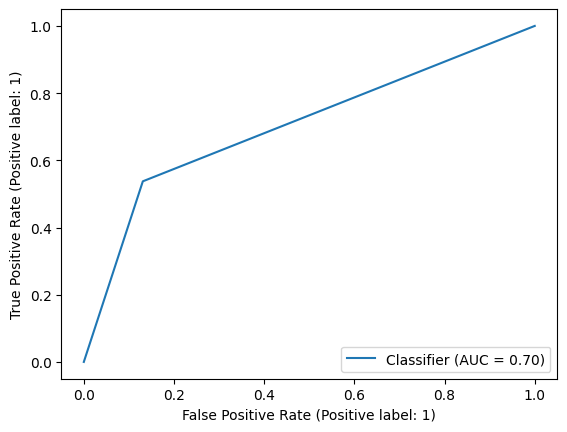

In [8]:
#ROC

from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(pipeline_log_reg,X,y, cv=skf, n_jobs=-1)

roc=RocCurveDisplay.from_predictions(y,y_pred)

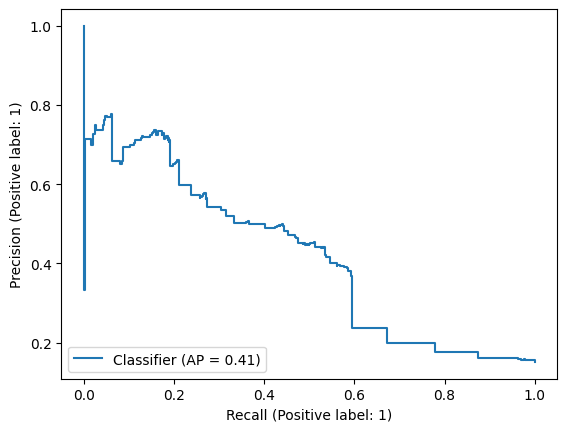

In [9]:
#Precision-Recall

from sklearn.metrics import PrecisionRecallDisplay

y_pred = cross_val_predict(pipeline_log_reg,X,y, cv=skf, n_jobs=-1, method='decision_function')

prc=PrecisionRecallDisplay.from_predictions(y,y_pred)

## Análise para entender os melhores parâmetros para esse modelo

In [10]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {

    "feature_selection__k": [10,15,20,25],
    'model__C': np.logspace(-3,3,7),
    'model__solver' : ['liblinear','saga','lbfgs'],
    'model__penalty' : ['l1','l2','elasticnet','none']
}

grid_search = GridSearchCV(
    pipeline_log_reg,
    param_grid,
    scoring=['roc_auc', 'average_precision', 'accuracy'],
    n_jobs=-1,
    refit='average_precision'
)

In [11]:
#O warning resultante é devido a combinação de solver e penalty que não é prevista na própria documentação
grid_search.fit(X,y)

c:\Users\gustavo.martins\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
700 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gustavo.martins\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gustavo.martins\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\gustavo.martins\

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one-hot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'AgeGroup',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'Complain',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'YearsSinceEnrolled',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'clus...
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

In [12]:
grid_search.best_params_

{'feature_selection__k': 25,
 'model__C': 1000.0,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

In [13]:
grid_search.best_score_

0.5863726150989814

In [14]:
print(*grid_search.cv_results_.keys(), sep='\n')

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_feature_selection__k
param_model__C
param_model__penalty
param_model__solver
params
split0_test_roc_auc
split1_test_roc_auc
split2_test_roc_auc
split3_test_roc_auc
split4_test_roc_auc
mean_test_roc_auc
std_test_roc_auc
rank_test_roc_auc
split0_test_average_precision
split1_test_average_precision
split2_test_average_precision
split3_test_average_precision
split4_test_average_precision
mean_test_average_precision
std_test_average_precision
rank_test_average_precision
split0_test_accuracy
split1_test_accuracy
split2_test_accuracy
split3_test_accuracy
split4_test_accuracy
mean_test_accuracy
std_test_accuracy
rank_test_accuracy


#### Melhores valores das combinações

In [15]:
np.nanmax(grid_search.cv_results_['mean_test_average_precision'])

0.5863726150989814

In [16]:
np.nanmax(grid_search.cv_results_['mean_test_roc_auc'])

0.8638011298232545

In [17]:
np.nanmax(grid_search.cv_results_['mean_test_accuracy'])

0.8489795918367348

In [18]:
grid_search.cv_results_['params'][np.nanargmax(grid_search.cv_results_['mean_test_average_precision'])]

{'feature_selection__k': 25,
 'model__C': 1000.0,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

In [19]:
grid_search.cv_results_['params'][np.nanargmax(grid_search.cv_results_['mean_test_roc_auc'])]

{'feature_selection__k': 25,
 'model__C': 10.0,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

In [20]:
grid_search.cv_results_['params'][np.nanargmax(grid_search.cv_results_['mean_test_accuracy'])]

{'feature_selection__k': 10,
 'model__C': 0.001,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

In [21]:
df_results_gs = pd.DataFrame(
        {
            'auprc': grid_search.cv_results_['mean_test_average_precision'],
            'auroc': grid_search.cv_results_['mean_test_roc_auc'],
            'accuracy': grid_search.cv_results_['mean_test_accuracy'],
        }

)

<Axes: >

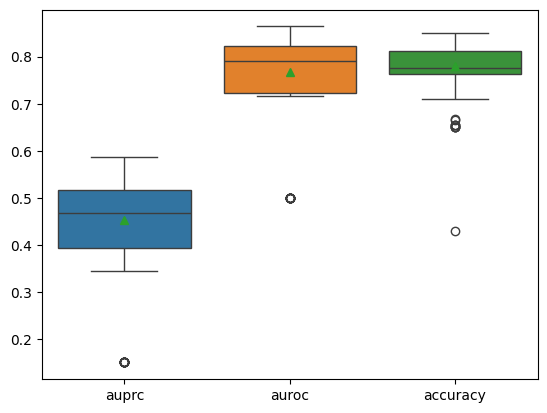

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(
    data=df_results_gs,
    showmeans=True
)

In [23]:
grid_search.best_params_

{'feature_selection__k': 25,
 'model__C': 1000.0,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

In [24]:
pipeline_log_reg_best = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif, k=grid_search.best_params_['feature_selection__k'])),
        ("rus", RandomUnderSampler(random_state=RANDOM_STATE)), #balanceando a base
        ("model", LogisticRegression(
            random_state=RANDOM_STATE, 
            C= grid_search.best_params_['model__C'],
            penalty= grid_search.best_params_['model__penalty'],
            solver= grid_search.best_params_['model__solver']
            )),
    ]
)

scores = cross_validate(
    pipeline_log_reg_best,
    X,
    y,
    cv=skf,
    scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
    n_jobs=-1
)

In [25]:
scores

{'fit_time': array([0.2308073 , 0.24710155, 0.23642254, 0.25351787, 0.23477221]),
 'score_time': array([0.06401277, 0.05832624, 0.0648489 , 0.06416154, 0.06401753]),
 'test_accuracy': array([0.75283447, 0.7755102 , 0.76870748, 0.80272109, 0.75056689]),
 'test_precision': array([0.34782609, 0.37096774, 0.36641221, 0.416     , 0.35333333]),
 'test_recall': array([0.71641791, 0.68656716, 0.71641791, 0.78787879, 0.8030303 ]),
 'test_roc_auc': array([0.83240881, 0.83055312, 0.83755687, 0.89379798, 0.85371717]),
 'test_average_precision': array([0.57409474, 0.57116889, 0.51929956, 0.66347353, 0.56752647])}

In [26]:
scores['time'] = scores['fit_time'] + scores['score_time']

df_scores_best = pd.DataFrame(scores)

df_scores_best

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,0.230807,0.064013,0.752834,0.347826,0.716418,0.832409,0.574095,0.294820
1,0.247102,0.058326,0.775510,0.370968,0.686567,0.830553,0.571169,0.305428
2,0.236423,0.064849,0.768707,0.366412,0.716418,0.837557,0.519300,0.301271
3,0.253518,0.064162,0.802721,0.416000,0.787879,0.893798,0.663474,0.317679
4,0.234772,0.064018,0.750567,0.353333,0.803030,0.853717,0.567526,0.298790


C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_39160\4226099603.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_39160\4226099603.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_39160\4226099603.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_39160\4226099603.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b

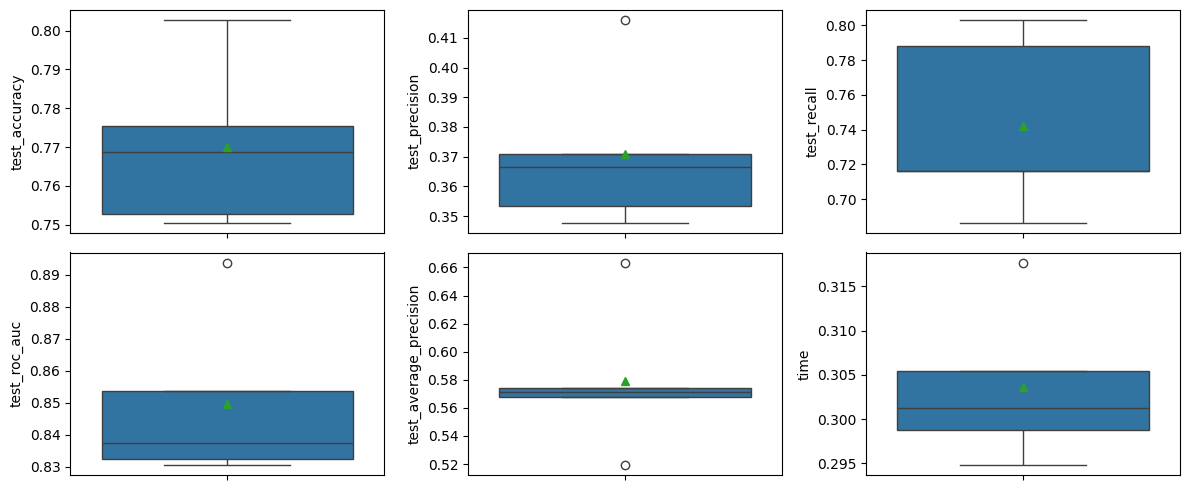

In [27]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,5), tight_layout = True)

cols = df_scores_best.columns[2:].to_list()

for ax, col in zip(axs.flatten(), cols):

    b = sns.boxplot( y=col, data=df_scores_best, ax=ax, showmeans=True)

    b.set_xticklabels(b.get_xticklabels(), fontsize=7)

plt.show()

### Verificando a importancia das features para o peso do modelo

In [30]:
pipeline_log_reg_best.fit(X,y)
names = pipeline_log_reg_best[:-1].get_feature_names_out()

c:\Users\gustavo.martins\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
importance = pipeline_log_reg_best['model'].coef_[0]

In [33]:
df_importance = pd.DataFrame(
    {
        'name': names,
        'importance': importance
    }
)

df_importance.sort_values(by='importance')

,name,importance
18,minmax__Recency,-3.087456
14,one-hot__AcceptedCmpTotal_1,-1.927740
15,one-hot__AcceptedCmpTotal_2,-1.049683
24,power__MntProds,-0.822502
2,one-hot__HasAcceptedCmp_0,-0.803894
13,one-hot__AcceptedCmpTotal_0,-0.803894
17,one-hot__cluster_1,-0.774799
20,power__MntWines,-0.667209
16,one-hot__AcceptedCmpTotal_3,-0.616180
6,one-hot__AcceptedCmp3_0,-0.504209


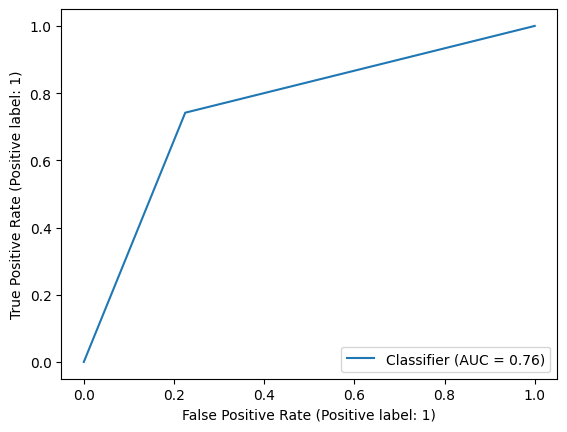

In [34]:
#ROC

from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(pipeline_log_reg_best,X,y, cv=skf, n_jobs=-1)

roc=RocCurveDisplay.from_predictions(y,y_pred)

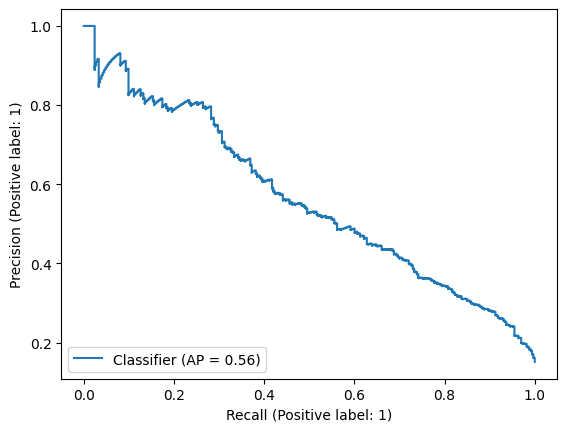

In [35]:
#Precision-Recall

from sklearn.metrics import PrecisionRecallDisplay

y_pred = cross_val_predict(pipeline_log_reg_best,X,y, cv=skf, n_jobs=-1, method='decision_function')

prc=PrecisionRecallDisplay.from_predictions(y,y_pred)